In [1]:
import numpy as np
from scipy.interpolate import interp1d
import os

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def find_file(datapath, startswith):
    # look for file in folder `datapath` that starts with `startswith`
    filename = ''
    for file in os.listdir(datapath):
        if file.startswith(startswith) and file.endswith('.npz'):
            filename = file
    
    return filename

In [3]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [4]:
def fit_gamma(x, y):
    x = np.array(x)
    y = np.array(y)
    # for all points (x,y), calculate r and compare to predicted
    best_err = np.inf
    best_gamma = 0
    for gamma in np.linspace(-2, 3, 100):
        err = np.sum(np.abs( np.sqrt(x**2 + y**2 + gamma * x * y) - 1))
        if err < best_err:
            best_err = err
            best_gamma = gamma
    return best_gamma

In [5]:
def movie2bright(pt, mode='softmax'):
    if mode == 'max':
        return pt.max()
    elif mode == 'softmax':
        # frame-wise softmax
        return (np.exp(pt) / np.exp(pt).sum(axis=(0,1))).max(axis=(0,1)).max()
    elif mode == 'mean':
        # frame-wise mean
        return pt.mean(axis=(0,1)).max()
    else:
        raise ValueError('Unknown mode "' + mode + '"')

In [6]:
def get_isobrightness(data, exp_params, mode='max'):
    # This is the reference current that produces the reference brightness
    # we are trying to match
    amp_ref = exp_params['amp_ref']
    
    # Find reference brightness from single-electrode conditions
    # Condition 1
    x1 = data['cond1']['amp_E1'][0]
    match_b1 = movie2bright(data['cond1']['frames'][0].data, mode)
    
    # Condition 2
    x2 = data['cond2']['amp_E2'][0]
    match_b2 = movie2bright(data['cond2']['frames'][0].data, mode)
    
    gamma = []
    amp1 = []
    amp2 = []
    # For all other delays, compare delayed-pulse responses to match_b1 and match_b2
    for d in np.unique(data['cond3']['delay']):
        # indices where delay is d
        idx = np.where(data['cond3']['delay'] == d)[0]
        idx_start = idx[0]
        idx_end = idx[-1] + 1

        # From Condition 2 above
        plot_amp1 = [0]
        plot_amp2 = [1]

        # Condition 3
        x3 = data['cond3']['amp_E2'][idx_start:idx_end]
        y3 = [movie2bright(f.data, mode) for f in data['cond3']['frames'][idx_start:idx_end]]
        amp_b3 = fit_amps(x3, y3, match_b2)
        plot_amp1.append(data['cond3']['amp_E1'][2] / amp_ref)
        plot_amp2.append(amp_b3 / amp_ref)

        # Condition 5
        x5 = data['cond5']['amp_E1'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5 = np.maximum(0, fit_amps(x5, y5, match_b1))
        plot_amp1.append(amp_b5 / amp_ref)
        x5 = data['cond5']['amp_E2'][idx_start:idx_end]
        y5 = [movie2bright(f.data, mode) for f in data['cond5']['frames'][idx_start:idx_end]]
        amp_b5 = np.maximum(0, fit_amps(x5, y5, match_b2))
        plot_amp2.append(amp_b5 / amp_ref)

        # Condition 4
        x4 = data['cond4']['amp_E1'][idx_start:idx_end]
        y4 = [movie2bright(f.data, mode) for f in data['cond4']['frames'][idx_start:idx_end]]
        amp_b4 = fit_amps(x4, y4, match_b1)
        plot_amp1.append(amp_b4 / amp_ref)
        plot_amp2.append(data['cond4']['amp_E2'][3] / amp_ref)

        # From Condition 1 above
        plot_amp1.append(1)
        plot_amp2.append(0)
        
        g = fit_gamma(np.array(plot_amp1), np.array(plot_amp2))
        if g < -1 or g > 2:
            print('(%s, %s, delay=%d): gamma=%f out of whack, clip' % (exp_params['name_E1'],
                                                                       exp_params['name_E2'],
                                                                       d, g))
            g = np.maximum(-1, np.minimum(2, g))
            
        gamma.append(g)
        amp1.append(plot_amp1)
        amp2.append(plot_amp2)
        
    return (amp1, amp2, gamma)

In [7]:
def plot_iso_fit(gamma, color='k', style='-', linewidth=2):
    x = np.linspace(0, 1, 100)
    y = 0.5 * (np.sqrt(gamma**2 * x**2 - 4 * x**2 + 4) - gamma * x)
    
    plt.plot(x, y, style, c=color, linewidth=linewidth)
    plt.plot(y, x, style, c=color, linewidth=linewidth)

In [80]:
def plot_isobrightness(amp_E1, amp_E2, gamma, delay, exp_params, save_fig=True, save_dir=''):
    from matplotlib.cm import gray as cmap
    
    pair = '(%s, %s)' % (exp_params['name_E1'], exp_params['name_E2'])
    plt.close()
    
    plt.fill_between([0, 1], [1, 1], color='lightgray', alpha=0.5)
    colors = [i / len(gamma) for i in range(len(gamma))]
    for e1, e2, c in zip(amp_E1, amp_E2, colors):
        plt.plot(e1, e2, 'o', color=cmap(c), label=0, linewidth=2)
    for g, c in zip(gamma, colors):
        plot_iso_fit(g, cmap(c))
    plot_iso_fit(-1, 'k', ':', 1)
    plot_iso_fit(0, 'k', ':', 1)
    plot_iso_fit(1, 'k', ':', 1)
    plot_iso_fit(2, 'k', ':', 1)
    plt.xlabel('E1')
    plt.ylabel('E2')
    plt.legend(loc='upper right')
    plt.title(pair)
    plt.axis([-0.2, 1.2, 0, 1.2])
    plt.axis('equal')
#     plt.legend(delay * 1000)
    plt.ylim(0, 1.2)
    plt.xlim(-0.2, 1.5)

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [0.2, 0.2, 0.25, 0.25]
    ax2 = plt.axes([left, bottom, width, height])
    ax2.plot(gamma, 'o-k')
    ax2.plot([0, len(delay) - 1], [0, 0], ':k')
    ax2.plot([0, len(delay) - 1], [1, 1], ':k')
    plt.xticks(range(len(delay)), delay * 1000)
    plt.yticks([-1, 0, 1, 2])
    plt.xticks([])
    plt.ylim(-1, 2)
    
    
    if save_fig:
        if save_dir == '':
            save_dir = exp_params['save_dir']
        else:
            if not save_dir.endswith('/'):
                save_dir += '/'
        filename = '%s%s_%s_%s_%s_%.2fX_iso_%s' % (save_dir, 
                                                   exp_params['name'], 
                                                   exp_params['name_E1'], 
                                                   exp_params['name_E2'], 
                                                   exp_params['date'], 
                                                   exp_params['fac_thresh'],
                                                   mode)
        plt.savefig(filename + '.png')
        plt.savefig(filename + '.eps')
        print('Saved figure to %s.{eps,png}' % filename)

In [81]:
def plot_gamma(all_gamma, delay, mode, prefix='', save_fig=True, save_dir=''):
    all_gamma = np.array(all_gamma)
    x_min = np.minimum(-1, np.floor(all_gamma.min()))
    x_max = np.maximum(1, np.ceil(all_gamma.max()))
    plt.hist(all_gamma, stacked=True, label=delay * 1000, bins=11, range=(x_min, x_max))
    plt.xlabel('gamma')
    plt.ylabel('count')
    plt.legend()
    plt.title('movie2brightness: ' + mode)
    if save_fig:
        if save_dir == '':
            save_dir = exp_params['save_dir']
        else:
            if not save_dir.endswith('/'):
                save_dir += '/'
        filename = '%s%s%s_%s_%.2fX_gamma_%s' % (save_dir, 
                                                 prefix,
                                                 exp_params['name'],
                                                 exp_params['date'], 
                                                 exp_params['fac_thresh'],
                                                 mode)
        plt.savefig(filename + '.png')
        plt.savefig(filename + '.eps')
        print('Saved figure to %s.{eps,png}' % filename)

Loading file nanduri_A1_A4_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_A1_A4_2016-11-05_1.50X_iso_max.{eps,png}


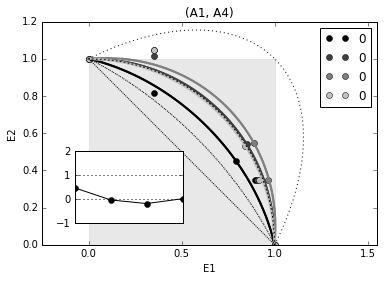

In [82]:
# how to get brightness from pulse train
# {'max', 'softmax', 'mean'}
mode = 'max'

datapath = 'data/lambda8_rot0_1.50X_area/'
prefix = 'nanduri'

# all pairs that are 800um away
# idx_E1  = [   2,   0,  10,   2,  10,  6,   9,   12]
# name_E1 = ['C1','A1','C3','C1','C3','C2','B3','A4']
# idx_E2  = [   3,   4,   6,   1,   5,  5,   5,   13]
# name_E2 = ['D1','A2','C2','B1','B2','B2','B2','B4']


# all S06
idx_E1  = [   9,  10,   0,   5,   9,   2,   0,  12,   6,   0,  4 ]
name_E1 = ['B3','C3','A1','B2','B3','C1','A1','A4','C2','A1','A2']
idx_E2  = [   1,   5,   4,  13,   5,   1,   2,  13,   5,   4,  6 ]
name_E2 = ['B1','B2','A4','B4','B2','B1','C1','B4','B2','A2','C2']

name_E1 = ['A1']
name_E2 = ['A4']

all_amp1 = []
all_amp2 = []
all_gamma = []
for E1, E2 in zip(name_E1, name_E2):
    # Load data from file, auto-complete file name
    filestr = '%s_%s_%s_' % (prefix, E1, E2)
    filename = find_file(datapath, filestr)
    
    if filename == '':
        print('Could not locate file "' + datapath + filestr + '*", skip')
        continue
    else:
        print('Loading file ' + filename)

    exp_data = np.load(datapath + filename)
    data = exp_data['data'][()]
    exp_params = exp_data['exp_params'][()]
    
    # calculate isobrightness curve
    amp1, amp2, gamma = get_isobrightness(data, exp_params, mode=mode)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)
    
    # find delays from file specs
    delay = np.unique(data['cond3']['delay'])
    plot_isobrightness(amp1, amp2, gamma, delay, exp_params, save_dir=datapath)

Saved figure to data/lambda8_rot0_1.50X_area/S06nanduri_2016-11-05_1.50X_gamma_max.{eps,png}


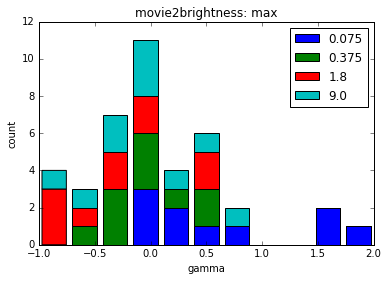

In [37]:
plot_gamma(all_gamma, delay, mode, prefix='S06', save_dir=datapath)

Loading file nanduri_B2_B4_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_B2_B4_2016-11-05_1.50X_iso_max.{eps,png}
Loading file nanduri_A2_C2_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_A2_C2_2016-11-05_1.50X_iso_max.{eps,png}
Loading file nanduri_B3_B1_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_B3_B1_2016-11-05_1.50X_iso_max.{eps,png}
Loading file nanduri_A1_C1_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_A1_C1_2016-11-05_1.50X_iso_max.{eps,png}
Loading file nanduri_A1_A4_2016-11-05_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_A1_A4_2016-11-05_1.50X_iso_max.{eps,png}
Loading file nanduri_C4_C1_2016-11-06_1.5X.npz
Saved figure to data/lambda8_rot0_1.50X_area/nanduri_C4_C1_2016-11-06_1.50X_iso_max.{eps,png}


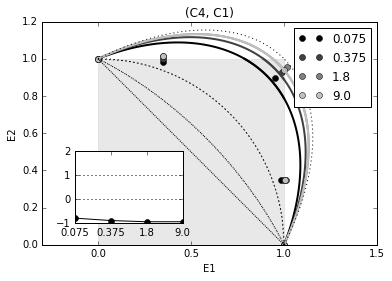

In [18]:
# how to get brightness from pulse train
# {'max', 'softmax', 'mean'}
mode = 'max'

# all pairs that are > 800um away
idx_E1  = [   5,   4,   9,   0,  0,   14]
name_E1 = ['B2','A2','B3','A1','A1','C4']
idx_E2  = [  13,   6,   1,   2,  12,   2]
name_E2 = ['B4','C2','B1','C1','A4','C1']

all_amp1 = []
all_amp2 = []
all_gamma = []
for E1, E2 in zip(name_E1, name_E2):
    # Load data from file, auto-complete file name
    filestr = '%s_%s_%s_' % (prefix, E1, E2)
    filename = find_file(datapath, filestr)

    if filename == '':
        print('Could not locate file "' + datapath + filestr + '*", skip')
        continue
    else:
        print('Loading file ' + filename)

    exp_data = np.load(datapath + filename)
    if 'data' in exp_data.files:
        data = exp_data['data'][()]
    else:
        print('File does not contain "data", skip')
        continue
        
    if 'exp_params' in exp_data.files:
        exp_params = exp_data['exp_params'][()]
    else:
        print('File does not contain "exp_params", skip')
        continue
    
    # calculate isobrightness curve
    amp1, amp2, gamma = get_isobrightness(data, exp_params, mode=mode)
    all_amp1.append(amp1)
    all_amp2.append(amp2)
    all_gamma.append(gamma)
    
    # find delays from file specs
    delay = np.unique(data['cond3']['delay'])
    plot_isobrightness(amp1, amp2, gamma, delay, exp_params, save_dir=datapath)

Saved figure to data/lambda8_rot0_1.50X_area/1600um_nanduri_2016-11-06_1.50X_gamma_max.{eps,png}


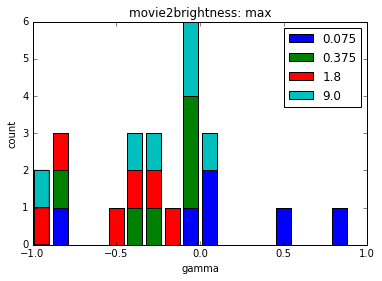

In [29]:
plot_gamma(all_gamma, delay, mode, prefix='1600um_', save_dir=datapath)